# Speech Understanding Major Exam

## ***Question 2***

In [ ]:
# @title ✅ SETUP: Install Dependencies
#  =====================================
# ✅ SETUP: Install Dependencies
# =====================================
!pip install --upgrade --force-reinstall numpy numba whisper openai-whisper
!pip install torchaudio librosa jiwer soundfile --quiet
!pip install git+https://github.com/ludlows/python-pesq  # Optional PESQ

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Using cached whisper-1.1.10-py3-none-any.whl
  Using cached openai_whisper-20240930-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.8 MB/s eta 0:00:00
  Using cached tiktoken-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.

ERROR: Operation cancelled by user
^C
^C


In [ ]:
# @title Import Required Libraries
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import whisper
import shutil
from jiwer import wer
from IPython.display import Audio, display
from scipy.signal import spectrogram
from scipy.signal import wiener
from pathlib import Path
import torch
import torchaudio
import soundfile as sf
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# @title 🔄 MOUNT GOOGLE DRIVE
# =====================================
# 🔄 MOUNT GOOGLE DRIVE
# =====================================
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# I have saved the files in my drive as per the folder structure given
# ==========================================
# ✅ CONFIG PATHS
# ==========================================
base_path = "/content/drive/MyDrive/denoising samples"
clean_dir = os.path.join(base_path, "set 1 - Clean and noisy", "clean")
noisy_dir = os.path.join(base_path, "set 1 - Clean and noisy", "noisy")
set2_dir = os.path.join(base_path, "set 2 - only noisy")
output_dir = "/content/denoised_output"
os.makedirs(output_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
# @title 🔊 FUNCTION: SNR Calculation
# =====================================
# 🔊 FUNCTION: SNR Calculation
# =====================================
def calculate_snr(clean, noisy):
    signal_power = np.sum(clean ** 2)
    noise_power = np.sum((clean - noisy) ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    return snr

In [ ]:
# @title 🎵 VISUALIZATION: Plot Spectrogram
# =====================================
# 🎵 VISUALIZATION: Plot Spectrogram
# =====================================
def plot_spectrogram(signal, sr, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    S = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(S))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

In [ ]:
# @title 🧹 DENOISING USING WIENER
# =====================================
# 🧹 DENOISING USING WIENER
# =====================================
def denoise_with_wiener(input_path, output_path):
    signal, sr = librosa.load(input_path, sr=None)

    # Add small random noise to avoid divide-by-zero
    signal += 1e-10 * np.random.randn(*signal.shape)

    denoised = wiener(signal)
    denoised = np.nan_to_num(denoised, nan=0.0)

    # Save denoised audio
    sf.write(output_path, denoised, sr)

    return denoised, sr

In [ ]:
# @title 📄 TRANSCRIPTION USING WHISPER
# =====================================
# 📄 TRANSCRIPTION USING WHISPER
# =====================================
whisper_model = whisper.load_model("base")
def transcribe(audio_array, sr):
    temp_path = "/content/temp.wav"
    sf.write(temp_path, audio_array, sr)
    result = whisper_model.transcribe(temp_path)
    return result["text"]

In [ ]:
# @title 📄 SAVE TABLES USING MATPLOTLIB
# =====================================
# 📄 SAVE TABLES USING MATPLOTLIB
# =====================================
import textwrap

def save_table_as_image(df, filename, title=""):
    # Wrap text for all columns
    wrapped_df = df.copy()
    max_col_width = 50  # Adjust for how much text you want before wrapping

    for col in wrapped_df.columns:
        wrapped_df[col] = wrapped_df[col].astype(str).apply(
            lambda x: '\n'.join(textwrap.wrap(x, width=max_col_width))
        )

    # Auto-figure size based on rows/columns
    fig_width = max(12, min(40, len(wrapped_df.columns) * 4))
    fig_height = max(6, len(wrapped_df) * 1 + 2)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')

    # Create table
    table = ax.table(
        cellText=wrapped_df.values,
        colLabels=wrapped_df.columns,
        loc='center',
        cellLoc='left',
        colWidths=[1.0 / len(wrapped_df.columns)] * len(wrapped_df.columns)
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)

    # ✅ Increase cell height
    table.scale(1.2, 4.0)  # ← adjust Y scale (4.0 = Quadrupal height)

    # Format headers and align text
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_fontsize(10)
            cell.set_text_props(weight='bold')
        cell.set_linewidth(0.5)
        cell.get_text().set_horizontalalignment('left')

    if title:
        plt.title(title, fontsize=14, weight='bold')

    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved: {filename}")

In [ ]:
# @title 🚀 MAIN PIPELINE: For SET 1
# =====================================
# 🚀 MAIN PIPELINE: For SET 1
# =====================================
set1_results = []

for file in sorted(os.listdir(noisy_dir)):
    if not file.endswith(".wav"):
        continue

    # File match logic...
    file_num = file.split("_")[-1].replace(".wav", "")
    clean_file = f"Datasets_clean_testset_wav_p232_{file_num}.wav"
    noisy_path = os.path.join(noisy_dir, file)
    clean_path = os.path.join(clean_dir, clean_file)

    print(f"Processing Set 1 file: {file} | Clean Match: {clean_file}")

    if not os.path.exists(clean_path):
        continue

    # Output path
    output_filename = file.replace(".wav", "_denoised.wav")
    output_path = os.path.join("/content/denoised_output", output_filename)

    # Load clean and noisy
    noisy, sr = librosa.load(noisy_path, sr=None)
    clean, _ = librosa.load(clean_path, sr=sr)

    # Denoise and save
    denoised, sr = denoise_with_wiener(noisy_path, output_path)

    # SNR
    snr_before = calculate_snr(clean, noisy)
    snr_after = calculate_snr(clean, denoised)

    # Transcriptions
    transcript_clean = transcribe(clean, sr)
    transcript_denoised = transcribe(denoised, sr)

    # WER
    error_rate = wer(transcript_clean, transcript_denoised)

    # Plots
    plot_spectrogram(noisy, sr, title=f"[Set 1] Noisy - {file}")
    plot_spectrogram(denoised, sr, title=f"[Set 1] Denoised - {file}")

    # Save result
    set1_results.append({
        "filename": file,
        "SNR Before": round(snr_before, 2),
        "SNR After": round(snr_after, 2),
        "WER": round(error_rate, 3),
        "Clean Transcript": transcript_clean,
        "Denoised Transcript": transcript_denoised
    })

# Display Set 1 Table
df1 = pd.DataFrame(set1_results)
display(df1)

In [ ]:
save_table_as_image(df1, "set1_table.png", title="Set 1 - SNR, WER, Transcriptions")

✅ Saved: set1_table.png


Processing Set 2 file: bus.wav


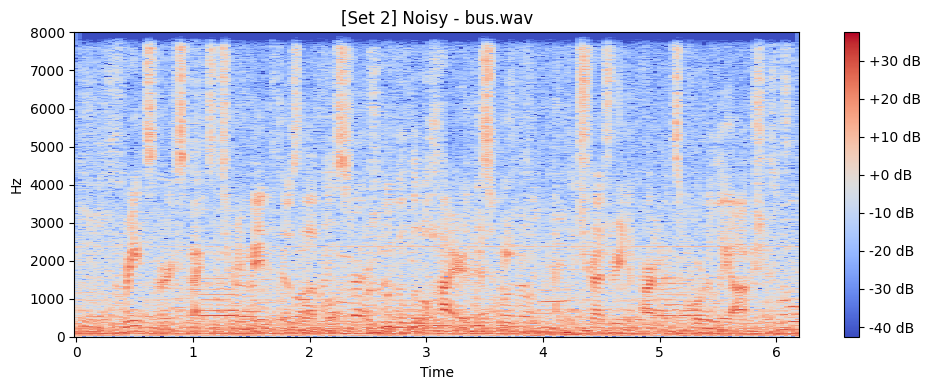

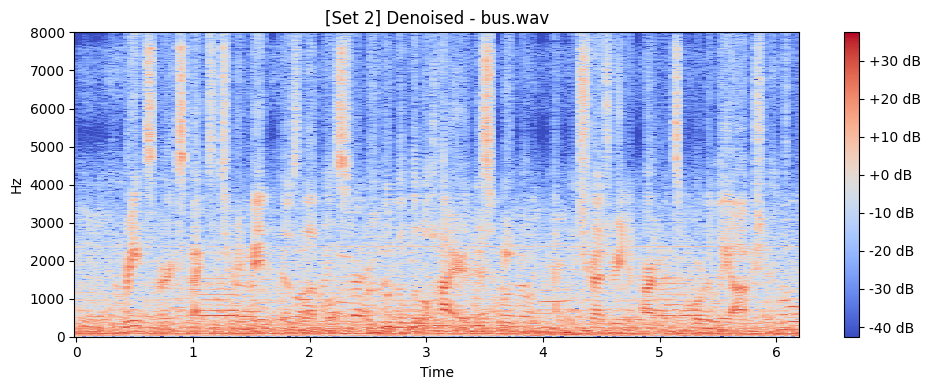

Processing Set 2 file: cafe.wav


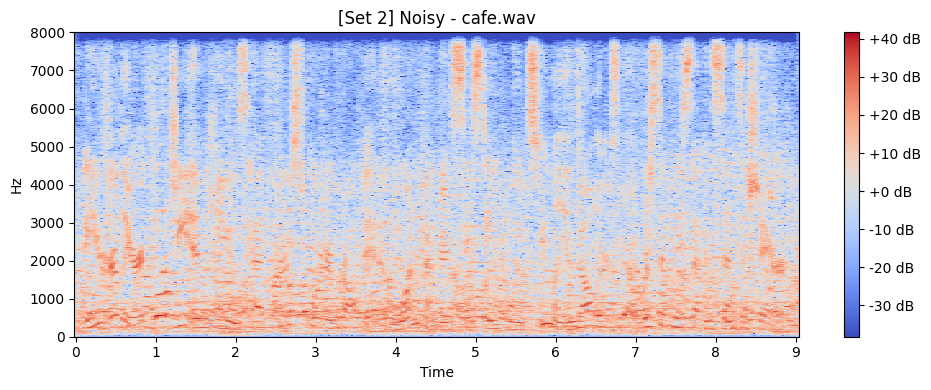

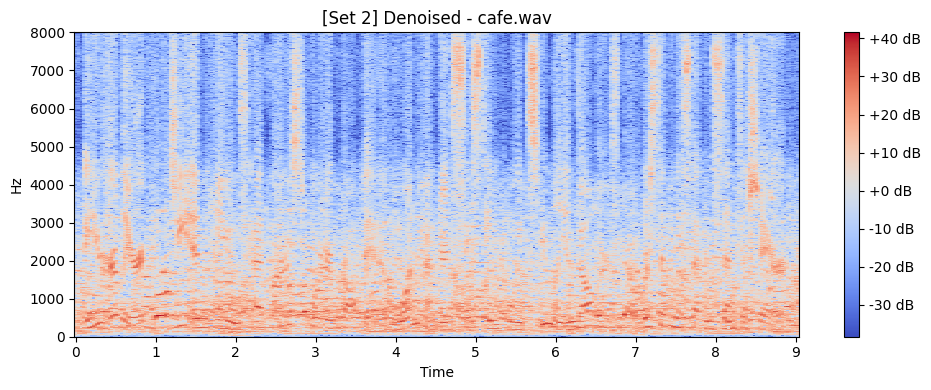

Processing Set 2 file: ped.wav


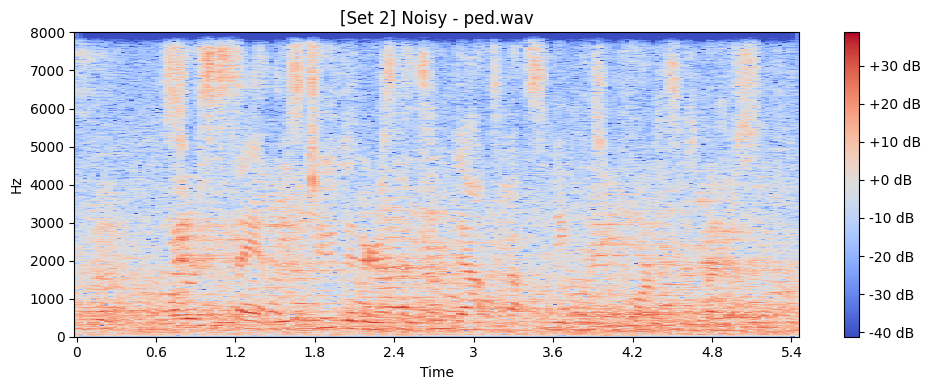

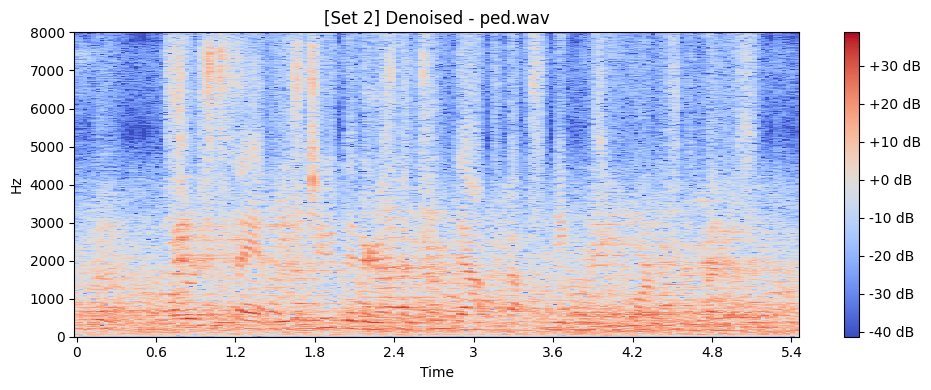

Processing Set 2 file: street.wav


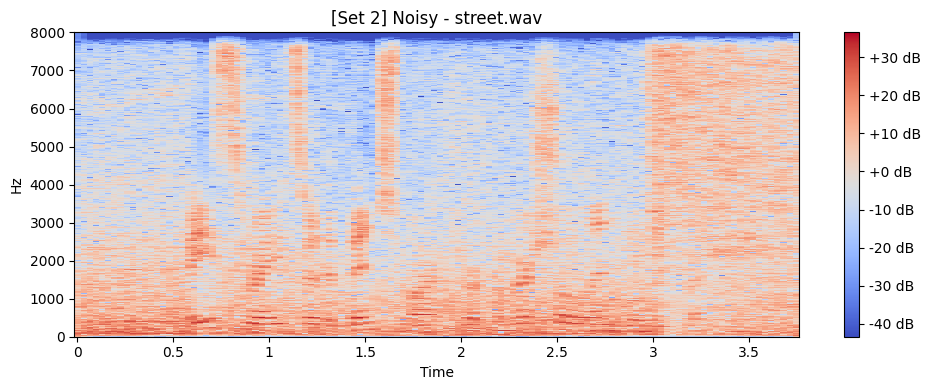

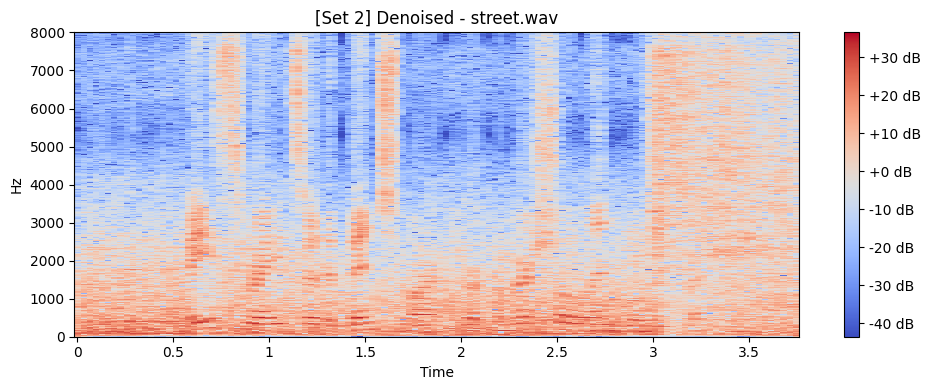

,filename,WER (Noisy→Denoised),Transcript (Noisy),Transcript (Denoised)
0,bus.wav,0.350,Grates are expected to remain at those levels...,Grates are expected to remain at those levels...
1,cafe.wav,0.533,"Earlier, GM Hughes had first quarter profit o...","But your earlier, GMFU's head first quarter p..."
2,ped.wav,0.714,sources say at least two bidders had some dou...,Scores say at least two bidders have sugar do...
3,street.wav,0.111,Base rates are the benchmark for commercial I...,Base rates are the benchmark for commercial l...


In [ ]:
# @title 🚀 PROCESS SET 2: Noisy Only
# =====================================
# 🚀 PROCESS SET 2: Noisy Only
# =====================================
set2_results = []
set2_files = ["bus.wav", "cafe.wav", "ped.wav", "street.wav"]

for file in set2_files:
    noisy_path = os.path.join(set2_dir, file)
    output_filename = file.replace(".wav", "_denoised.wav")
    output_path = os.path.join("/content/denoised_output", output_filename)
    print(f"Processing Set 2 file: {file}")

    # Load noisy and transcribe before denoising
    noisy, sr = librosa.load(noisy_path, sr=None)
    transcript_noisy = transcribe(noisy, sr)

    # Denoise and save
    denoised, sr = denoise_with_wiener(noisy_path, output_path)

    # Transcribe denoised audio
    transcript_denoised = transcribe(denoised, sr)

    # WER, comparing noisy and denoised audio. May not yield correct results since groun truth is questionable
    error_rate = wer(transcript_noisy, transcript_denoised)

    # Plots
    plot_spectrogram(noisy, sr, title=f"[Set 2] Noisy - {file}")
    plot_spectrogram(denoised, sr, title=f"[Set 2] Denoised - {file}")

    # Save result
    set2_results.append({
        "filename": file,
        "WER (Noisy→Denoised)": round(error_rate, 3),
        "Transcript (Noisy)": transcript_noisy,
        "Transcript (Denoised)": transcript_denoised
    })

# Display Set 2 Table
df2 = pd.DataFrame(set2_results)
display(df2)

In [ ]:
save_table_as_image(df2, "set2_table.png", title="Set 2 - Transcriptions")

✅ Saved: set2_table.png


In [ ]:
# @title 📊 DOWNLOAD TABLES & AUDIO
# =====================================
# 📊 DOWNLOAD TABLES & AUDIO
# =====================================
files.download("set1_table.png")
files.download("set2_table.png")
shutil.make_archive("/content/denoised_audio", 'zip', "/content/denoised_output")
files.download("/content/denoised_audio.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title 📝 FOR SUBJECTIVE EVALUATION (MOS)
# =====================================
# 📝 FOR SUBJECTIVE EVALUATION (MOS)
# =====================================
ratings = [5, 4, 5, 5, 4]  # Ratings from listeners
mos = sum(ratings) / len(ratings)
print("Listener Ratings:", ratings)
print("MOS (Mean Opinion Score):", round(mos, 2), "/ 5")

Listener Ratings: [5, 4, 5, 5, 4]
MOS (Mean Opinion Score): 4.6 / 5
